In [9]:
# Libraries import

import os, gc
import numpy as np
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, auc, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve

np.set_printoptions(suppress=True, precision = 3)

# Notes 

## Model architecture 
We train a random forest classifier, using a 5-fold cross-validation. The validation folds are designed using over-sampling so that in each fold, the validation set contains at least one tumor from each class, but possibly more so that each class has at least 15% of its data in validation. 

We select the most important features from the random forest model for experimental validation. We also use them to train a support vector classifier model, to boost the quality of the model. 

In [10]:
"""
DATA DESCRIPTION
Indicate the file names for the pre-processed data and for the tumor/non-tumor map. 
The pre-processed data is a list of dictionaries, one for each sample, each dictionary has the 2D x 1738 data
plus its methylation label, sample name, patient ID, , t-SNE and PCA decompositions (datastructure described below).
The tumor/non-tumor map is a list of numpy arrays, one for each sample, of the same 2D shape as the 
corresponding sample, coming in the same order as the samples in the pre-processed file. 
Each entry in the 2D array is 0/1, with 1 indicating that the corresponding spot in the pre-processed data 
was labeled as tumor. 
The map is to be used as filter: only those spot labeled as tumor are to be analysed further. 
We also use the map to extract the most discriminative features between tumor and non-tumor. 
"""

PREPROC_DATA_PATH = "../../data/preprocessed.npy"
TUMOR_MAP_PATH = "../../data/tumor_maps.npy"
LGM12_CLASSIFIER_PATH = "./LGm1-2_Models/" 

# Make the directory if it doesn't exist
if not os.path.exists(LGM12_CLASSIFIER_PATH[2:-1]):
    os.mkdir(LGM12_CLASSIFIER_PATH[2:-1])

SAMPLE_DICT_DATA_KEY = "data"
SAMPLE_DICT_NAME_KEY = "name"
SAMPLE_DICT_CLASS_ID_KEY = "class_id"
SAMPLE_DICT_PATIENT_ID_KEY = "patient_id"
SAMPLE_DICT_TSNE_KEY = "tsne"
SAMPLE_DICT_PCA_KEY = "pca"

# Define the samples to be excluded from the analysis (use their full name)
# These samples are either too noisy (1887) or too different from the others in their own class, 
# in other words not well covered with other samples and so, difficult to learn.
ignore = ["HF-1887_via-t_2_1.h5_3"]

# Define the classes we are intrested in. The IDs are 1, 2, 3, 4, 5, 6.
classes =[1, 2]

In [11]:
"""
CROSS-VALIDATION DESIGN: 5-fold
All samples (except 1887) included. Assigned to the CV folds in order of their names, 
trying to have about the same amount of validation data in each fold.
Date: February 2023. 
"""

LGm12_CV5folds=[ 
    [#Cv fold 1
        #LGm1 
        "HF-448_V5B_1.h5_3",
        #LGm2
        "HF-305_v4b_1_1.h5_6", "HF-615_V5BB_1.h5_9",  
        #LGm3
        "HF-2104_#5_1.h5_0", "HF-2104_#9_1.h5_1", "HF-2104_V1T_1.h5_2",
        #LGm4
        "HF-442_V4BB_1.h5_12", "HF-1002_V1AT_1.h5_0", "HF-1002_V2AT_1.h5_1", 
        #LGm5
        "HF-682_V3AT_1.h5_9", "HF-682_V3BB_1.h5_10", "HF-894_9_1.h5_11", "HF-894_V1BB_1.h5_12", 
        #LGm6
        "HF-592_V3T_1.h5_4", 
    ],
    [#Cv fold 2
        #LGm1 
        "HF-868_1_2.h5_4",
        #LGm2
        "HF-901_V2T_2.h5_10", "HF-960_VIAT_2.h5_11", 
        #LGm3
        "HF-2614_V1B_1.h5_3", 
        #LGm4
        "HF-1825_V2B_1.h5_2", "HF-2102_V2BB_1.h5_3", "HF-2102_V3AM_1.h5_4", "HF-2102_V3AM_2.h5_5", 
        #LGm5
        "HF-988_V1-T_1.h5_13", "HF-988_V1B_1.h5_14", "HF-1043_V1AM_1.h5_0", 
        #LGm6
        "HF-2106_V3AM_1.h5_0", 
    ], 
    [#Cv fold 3
        #LGm1 
        "HF-1293_13_1.h5_0",
        #LGm2
        "HF-1010_V1T_1.h5_0", "HF-1016_IAT_2.h5_1", "HF-1334_V58-B_2_1.h5_2", 
        #LGm3
        "HF-2849_VIT2_1.h5_4", "HF-2849_VIT2_1.h5_5", "HF-2849_VIT2_2.h5_6", "HF-2849_VIT_2_new2021.h5_7",
        #LGm4
        "HF-2454_V1AT_1.h5_6", "HF-2548_V1T_1.h5_7", 
        #LGm5
        "HF-1086_#1_1.h5_1", "HF-2355_V2AM_1.h5_2", 
        #LGm6
        "HF-2493_V1T_1.h5_1", "HF-2493_V1T_2.h5_2", 
    ], 
    [#Cv fold 4
        #LGm1 
        "HF-1295_V3AM_2.h5_1",
        #LGm2
        "HF-2070_V1T_1.h5_4", "HF-2776_V2B_2.h5_5",        
        #LGm3 
        "HF-2852_VIT_2_2.h5_8", 
        #LGm4
        "HF-2715_VIL_1.h5_8", "HF-2802_V3T_1.h5_9", 
        #LGm5
        "HF-2485_V1B_1.h5_3", "HF-2600_V1B_1.h5_4", "HF-2608_V1T_1.h5_5", 
        #LGm6
        "HF-2544_V1B_1.h5_3", 
    ],
    [#Cv fold 5
        #LGm1 
        "HF-2534_V2B_1.h5_2",
        #LGm2
        "HF-3271_VIB_2.h5_7", "HF-3337_V3T_1.h5_8", 
        #LGm3 same as fold 1
        "HF-2104_#5_1.h5_0", "HF-2104_#9_1.h5_1", "HF-2104_V1T_1.h5_2",
        #LGm4
        "HF-2876_V1T_1.h5_10", "HF-2898_V1T_1.h5_11",
        #LGm5
        "HF-2619_V1T_1.h5_6", "HF-2619_V4T_1.h5_7", "HF-2666_V2B_1.h5_8",
        #LGm6 same as fold 1
        "HF-592_V3T_1.h5_4", 
    ],
]

In [12]:
def reset_seed(SEED = 0):
    os.environ['PYTHONHASHSEED']=str(SEED)
    np.random.seed(SEED)
reset_seed(2022)

In [17]:
## Collect the RP curve for the RF, SVC models, already trained

def CrossValidation(data, labels, CV_folds=LGm12_CV5folds, verbose=False, pos_label=1):
    """ 
    This is the cross-validation training. 
    In each CV fold, the model is first trained, then the data reduced to its top 20 features
    and the model is re-trained with an SVC. 
    This is in the hope of reducing the noise and getting a better fit.
    We save all RF and SVC models, as well as their metrics. 
    """
    
    results = []  
    RFmetrics=[]
    SVCmetrics=[]
    index = 0
        
    # Initialize the ROC curve plotting data
    #RFtprs = []
    #RFaucs = []
    #SVCtprs = []
    #SVCaucs = []
    #mean_fpr = np.linspace(0, 1, 100)
    RFfig, RFax = plt.subplots(figsize=(6, 6))
    SVCfig, SVCax = plt.subplots(figsize=(6, 6))    
    
    RFy_real = []
    RFy_proba = []
    RFprecision_array = []
    RFrecall_array = np.linspace(0, 1, 100)

    SVCy_real = []
    SVCy_proba = []
    SVCprecision_array = []
    SVCrecall_array = np.linspace(0, 1, 100)
    
    # Loop through the CV folds
    for valid_fold in CV_folds:
        
        index = index+1
        if verbose: 
            print("Validation fold", index)
        CV_fold_name=str(index)

        # Get the train/validation data for this CV fold
        valid_names=[]
        valid_X=np.empty( (0,data[0][SAMPLE_DICT_DATA_KEY].shape[1]), dtype=float )
        valid_y=np.empty( 0, dtype=int )
        for (sample,label) in zip(data,labels): 
            if sample[SAMPLE_DICT_NAME_KEY] in valid_fold:
                valid_names.append(sample[SAMPLE_DICT_NAME_KEY])
                valid_X = np.append(valid_X, sample[SAMPLE_DICT_DATA_KEY], axis=0)
                valid_y = np.append(valid_y, label, axis=0)
        #if len(valid_names) != len(valid_fold):
        #    print("Error in the design of CV fold (data not found):", valid_fold)
        #    sys.exit(-1)     
            
        # Create RF model and train to extract features
        RFclf = joblib.load(LGM12_CLASSIFIER_PATH+"RF_" + CV_fold_name + ".RFmod")
         
        RFpred_proba = RFclf.predict_proba(valid_X)
        RFprecision_fold, RFrecall_fold, _ = precision_recall_curve(valid_y, RFpred_proba[:, pos_label-1], pos_label=pos_label)
        RFprecision_fold, RFrecall_fold = RFprecision_fold[::-1], RFrecall_fold[::-1]  # reverse order of results
        RFprec_array = np.interp(RFrecall_array, RFrecall_fold, RFprecision_fold)
        RFpr_auc = auc(RFrecall_array, RFprec_array)
        RFprecision_array.append(RFprec_array)

        RFlab_fold = 'Fold %d AUPR=%.4f' % (index, RFpr_auc)
        RFax.plot(RFrecall_fold, RFprecision_fold, alpha=0.3, label=RFlab_fold)
        RFy_real.append(valid_y)
        RFy_proba.append(RFpred_proba[:, pos_label-1])
                                
        # get a selector on the top 20 features
        selector = SelectFromModel(RFclf, prefit=True, threshold=-np.inf, max_features=20)
        del RFclf
        
        # project the training and the validation data
        sel_valid_X=selector.transform(valid_X)
        
        # Create a classifier: a support vector RBF classifier on the reduced features

        SVCclf = joblib.load(LGM12_CLASSIFIER_PATH+"SVC_" + CV_fold_name + ".SVCmod")
                       
        SVCpred_proba = SVCclf.predict_proba(sel_valid_X)
        SVCprecision_fold, SVCrecall_fold, _ = precision_recall_curve(valid_y, SVCpred_proba[:, pos_label-1], pos_label=pos_label)
        SVCprecision_fold, SVCrecall_fold = SVCprecision_fold[::-1], SVCrecall_fold[::-1]  # reverse order of results
        SVCprec_array = np.interp(SVCrecall_array, SVCrecall_fold, SVCprecision_fold)
        SVCpr_auc = auc(SVCrecall_array, SVCprec_array)
        SVCprecision_array.append(SVCprec_array)

        SVClab_fold = 'Fold %d AUPR=%.4f' % (index, SVCpr_auc)
        SVCax.plot(SVCrecall_fold, SVCprecision_fold, alpha=0.3, label=SVClab_fold)
        SVCy_real.append(valid_y)
        SVCy_proba.append(SVCpred_proba[:, pos_label-1])
        
        # Clear memory
        del SVCclf
        del valid_X
        del valid_y
        del sel_valid_X
        gc.collect()

    RFy_real = np.concatenate(RFy_real)
    RFy_proba = np.concatenate(RFy_proba)
    RFprecision, RFrecall, _ = precision_recall_curve(RFy_real, RFy_proba, pos_label=pos_label)
    RFlab = 'Overall AUPR=%.4f' % (auc(RFrecall, RFprecision))

    RFax.plot(RFrecall, 
              RFprecision, 
              lw=2, 
              color='red', 
              label=RFlab
             )

    RFmean_precision = np.mean(RFprecision_array, axis=0)
    RFstd_precision = np.std(RFprecision_array, axis=0)
    RFax.fill_between(
        RFrecall_array, 
        RFmean_precision + RFstd_precision, 
        RFmean_precision - RFstd_precision, 
        alpha=0.3, 
        linewidth=0, 
        color='grey'
    )
    
    RFax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="Recall (Sensitivity)",
        ylabel="Precision (PPV)",
        title="RF PR curves, class "+str(pos_label),
    )
    RFax.axis("square")
    RFax.legend(loc='lower left', fontsize='small') 
    
    SVCy_real = np.concatenate(SVCy_real)
    SVCy_proba = np.concatenate(SVCy_proba)
    SVCprecision, SVCrecall, _ = precision_recall_curve(SVCy_real, SVCy_proba, pos_label=pos_label)
    SVClab = 'Overall AUPR=%.4f' % (auc(SVCrecall, SVCprecision))

    SVCax.plot(SVCrecall, 
               SVCprecision, 
               lw=2, 
               color='red', 
               label=SVClab
              )

    SVCmean_precision = np.mean(SVCprecision_array, axis=0)
    SVCstd_precision = np.std(SVCprecision_array, axis=0)
    
    SVCax.fill_between(
        SVCrecall_array, 
        SVCmean_precision + SVCstd_precision, 
        SVCmean_precision - SVCstd_precision, 
        alpha=0.3, 
        linewidth=0, 
        color='grey'
    )
    
    SVCax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="Recall (Sensitivity)",
        ylabel="Precision (PPV)",
        title="SVC PR curves, class "+str(pos_label),
    )
    SVCax.axis("square")
    SVCax.legend(loc='lower left', fontsize='small')
    
    
    plt.show()

    return RFmetrics, SVCmetrics

In [18]:
# Read the pre-processed data and the tumor map of each sample
samples_0 = np.load(PREPROC_DATA_PATH, allow_pickle=True)
tumor_map_0 = np.load(TUMOR_MAP_PATH, allow_pickle=True)

samples = []
labels=[]

# Filter the data: retain only the tumor spots, based on the tumor map  
# Flatten the data (no spatial info needed here) 
# Skip the samples on the "ignore" list

for (sample, tumor) in zip(samples_0, tumor_map_0):    
    if sample[SAMPLE_DICT_NAME_KEY] in ignore:
        print("Sample ignored:", sample[SAMPLE_DICT_NAME_KEY])
        continue
    elif sample[SAMPLE_DICT_CLASS_ID_KEY] not in classes:
        print("Sample skipped:", sample[SAMPLE_DICT_NAME_KEY], "LGm", sample[SAMPLE_DICT_CLASS_ID_KEY])
        continue
    
    sample[SAMPLE_DICT_DATA_KEY] = sample[SAMPLE_DICT_DATA_KEY].reshape(-1, sample[SAMPLE_DICT_DATA_KEY].shape[2])
    tumor.resize(np.product(tumor.shape))
    sample[SAMPLE_DICT_DATA_KEY] = sample[SAMPLE_DICT_DATA_KEY][tumor == 1]
    samples.append(sample)
    
    label = sample[SAMPLE_DICT_CLASS_ID_KEY]
    # All spots get as label the methylation label of the entire sample
    labels.append(label*np.ones(sample[SAMPLE_DICT_DATA_KEY].shape[0], dtype=int))
    
del samples_0
del tumor_map_0
gc.collect()

Sample skipped: HF-442_V4BB_1.h5_12 LGm 4
Sample skipped: HF-592_V3T_1.h5_4 LGm 6
Sample skipped: HF-682_V3AT_1.h5_9 LGm 5
Sample skipped: HF-682_V3BB_1.h5_10 LGm 5
Sample skipped: HF-894_9_1.h5_11 LGm 5
Sample skipped: HF-894_V1BB_1.h5_12 LGm 5
Sample skipped: HF-988_V1-T_1.h5_13 LGm 5
Sample skipped: HF-988_V1B_1.h5_14 LGm 5
Sample skipped: HF-1002_V1AT_1.h5_0 LGm 4
Sample skipped: HF-1002_V2AT_1.h5_1 LGm 4
Sample skipped: HF-1043_V1AM_1.h5_0 LGm 5
Sample skipped: HF-1086_#1_1.h5_1 LGm 5
Sample skipped: HF-1825_V2B_1.h5_2 LGm 4
Sample ignored: HF-1887_via-t_2_1.h5_3
Sample skipped: HF-2102_V2BB_1.h5_3 LGm 4
Sample skipped: HF-2102_V3AM_1.h5_4 LGm 4
Sample skipped: HF-2102_V3AM_2.h5_5 LGm 4
Sample skipped: HF-2104_#5_1.h5_0 LGm 3
Sample skipped: HF-2104_#9_1.h5_1 LGm 3
Sample skipped: HF-2104_V1T_1.h5_2 LGm 3
Sample skipped: HF-2106_V3AM_1.h5_0 LGm 6
Sample skipped: HF-2355_V2AM_1.h5_2 LGm 5
Sample skipped: HF-2454_V1AT_1.h5_6 LGm 4
Sample skipped: HF-2485_V1B_1.h5_3 LGm 5
Sample skip

14714

Validation fold 1
Validation fold 2
Validation fold 3
Validation fold 4
Validation fold 5


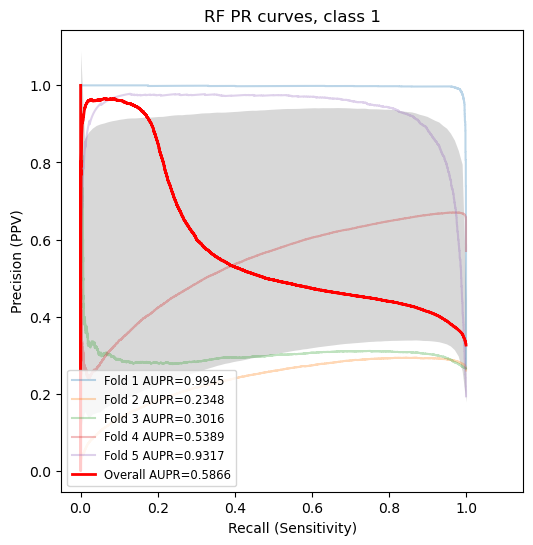

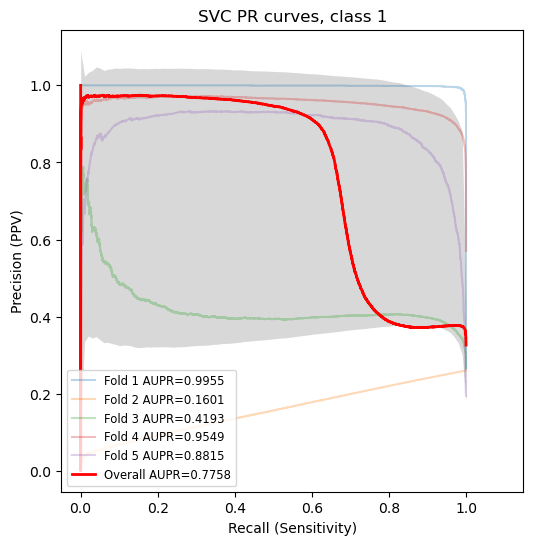

In [19]:
reset_seed(2022)
RFmetrics, SVCmetrics = CrossValidation(data=samples, 
                                        labels=labels, 
                                        CV_folds=LGm12_CV5folds, 
                                        verbose=True,
                                        pos_label=1
                                       )

Validation fold 1
Validation fold 2
Validation fold 3
Validation fold 4
Validation fold 5


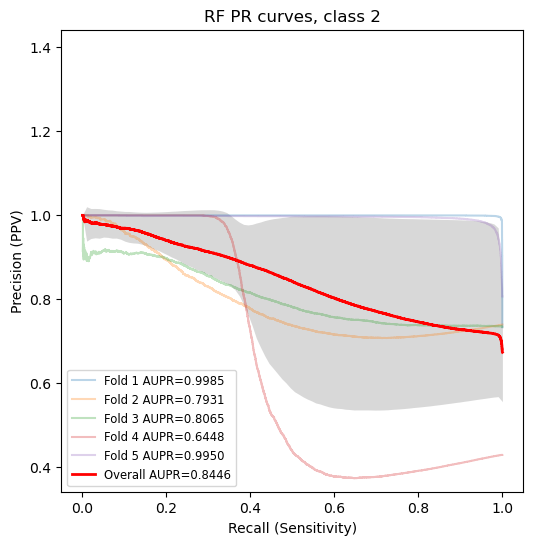

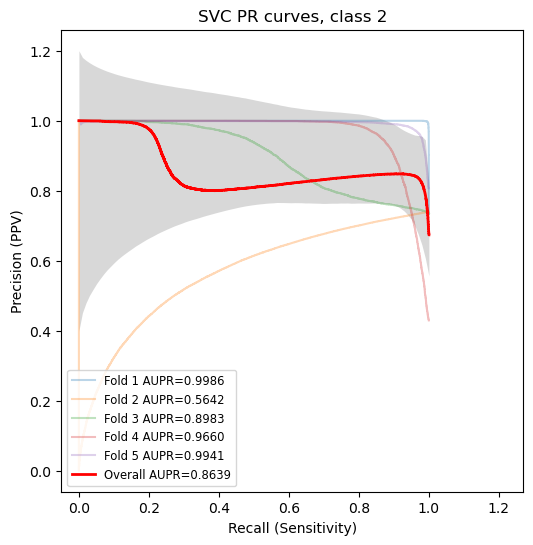

In [20]:
reset_seed(2022)
RFmetrics, SVCmetrics = CrossValidation(data=samples, 
                                        labels=labels, 
                                        CV_folds=LGm12_CV5folds, 
                                        verbose=True,
                                        pos_label=2
                                       )

In [21]:
results = np.mean(np.asanyarray(RFmetrics,dtype=object), axis=0)
print("\t Mean RF accuracy: ", results[0])
print("\t Mean RF AUROC:    ", results[1])
print("\t Mean RF precision:", results[2])
print("\t Mean RF recall:   ", results[3])
print("\t Mean RF F1:       ", results[4])
print("\t Mean RF confusion matrix:\n", results[5])
del results

/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ionpetre/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


IndexError: invalid index to scalar variable.

In [ ]:
results = np.mean(np.asanyarray(SVCmetrics,dtype=object), axis=0)
print("\t Mean SVC accuracy: ", results[0])
print("\t Mean SVC AUROC:    ", results[1])
print("\t Mean SVC precision:", results[2])
print("\t Mean SVC recall:   ", results[3])
print("\t Mean SVC F1:       ", results[4])
print("\t Mean SVC confusion matrix:\n", results[5])
del results

In [ ]:
del samples
del labels
gc.collect()